# Analysis of Factors Influencing Median Household Income
By James Thompson and Georgia Thomas

In [ ]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge, Lasso
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

# Data Fetching
The data comes from the US Census API.

In [ ]:
#fetch data
api_key = 'd62c055c9264ef4750cc52264f116f061ca8fae1'

def census_api_call(vars_list, api_key):
    base = "https://api.census.gov/data/2022/acs/acs5?"
    var_string = ",".join(vars_list)
    url = f"{base}get=NAME,{var_string}&for=county:*&key={api_key}"

    r = requests.get(url)

    if r.status_code != 200:
        print("API error:", r.text)
        raise Exception("API request failed")

    try:
        data = r.json()
    except:
        print("Raw response:")
        print(r.text[:500])
        raise

    cols = data[0]
    rows = data[1:]
    return pd.DataFrame(rows, columns=cols)

# Data Cleaning
The variables were labelled for clarity, age categories were grouped, and missing values were dropped.

In [ ]:
#income, population and education
vars1 = [
    "B19013_001E",  #income
    "B01003_001E",  #population
    "B15003_022E", "B15003_023E", "B15003_024E", "B15003_025E"  #education
]

df1 = census_api_call(vars1, api_key)
df1.head()

,NAME,B19013_001E,B01003_001E,B15003_022E,B15003_023E,B15003_024E,B15003_025E,state,county
0,"Autauga County, Alabama",68315,58761,6726,4014,702,437,01,001
1,"Baldwin County, Alabama",71039,233420,33474,15077,3483,2351,01,003
2,"Barbour County, Alabama",39712,24877,1167,640,188,105,01,005
3,"Bibb County, Alabama",50669,22251,1047,507,109,76,01,007
4,"Blount County, Alabama",57440,59077,3840,1751,270,156,01,009


In [ ]:
#race/hispanic origin
vars2 = [
    "B02001_002E",  #White alone
    "B02001_003E",  #Black alone
    "B02001_004E",  #AIAN
    "B02001_005E",  #Asian
    "B02001_006E",  #NHPI
    "B02001_008E",  #Two or more races
    "B03003_003E"   #Hispanic
]

df2 = census_api_call(vars2, api_key)
df2.head()

,NAME,B02001_002E,B02001_003E,B02001_004E,B02001_005E,B02001_006E,B02001_008E,B03003_003E,state,county
0,"Autauga County, Alabama",43747,11496,59,658,0,2480,1864,01,001
1,"Baldwin County, Alabama",195998,19445,848,2046,31,10638,11210,01,003
2,"Barbour County, Alabama",11309,11668,74,126,3,609,1202,01,005
3,"Bibb County, Alabama",16872,4603,21,69,0,578,650,01,007
4,"Blount County, Alabama",53941,729,227,100,117,2104,5721,01,009


In [ ]:
#age distributions
vars3 = [
    #0–17
    "B01001_003E","B01001_004E","B01001_005E","B01001_006E","B01001_007E",
    #18–34
    "B01001_010E","B01001_011E","B01001_012E","B01001_013E","B01001_014E",
    #35–64
    "B01001_017E","B01001_018E","B01001_019E","B01001_020E","B01001_021E",
    #65+
    "B01001_029E","B01001_030E","B01001_031E","B01001_032E","B01001_033E"
]

df3 = census_api_call(vars3, api_key)
df3.head()

,NAME,B01001_003E,B01001_004E,B01001_005E,B01001_006E,B01001_007E,B01001_010E,B01001_011E,B01001_012E,B01001_013E,...,B01001_019E,B01001_020E,B01001_021E,B01001_029E,B01001_030E,B01001_031E,B01001_032E,B01001_033E,state,county
0,"Autauga County, Alabama",1778,1805,2097,1272,604,1236,1882,1844,2211,...,931,436,881,2279,1434,614,117,524,01,001
1,"Baldwin County, Alabama",6278,6024,8418,4563,2753,3546,6204,6495,7537,...,5662,3166,3886,7719,4427,2577,980,1478,01,003
2,"Barbour County, Alabama",632,689,758,457,357,382,1055,977,854,...,583,308,433,580,441,200,101,32,01,005
3,"Bibb County, Alabama",534,734,709,483,247,403,924,1088,599,...,370,243,331,593,335,243,33,93,01,007
4,"Blount County, Alabama",1770,1851,2135,1426,637,1058,1926,1622,1814,...,1177,560,1060,2000,1068,574,206,247,01,009


In [ ]:
#mobility indicators
vars4 = [
    "B07001_004E",  #same house 1 year ago
    "B07001_007E",  #moved within county
    "B07001_010E"   #moved from other state
]

df4 = census_api_call(vars4, api_key)
df4.head()

,NAME,B07001_004E,B07001_007E,B07001_010E,state,county
0,"Autauga County, Alabama",1218,3689,4070,01,001
1,"Baldwin County, Alabama",5330,13251,14673,01,003
2,"Barbour County, Alabama",557,1678,1477,01,005
3,"Bibb County, Alabama",490,1608,1628,01,007
4,"Blount County, Alabama",1211,3334,3843,01,009


In [ ]:
#rename columns
df1 = df1.rename(columns={
    "B19013_001E": "Median household income",
    "B01003_001E": "Total population",

    #Education (ACS Table B15003)
    "B15003_022E": "Bachelor's degree",
    "B15003_023E": "Master's degree",
    "B15003_024E": "Professional degree",
    "B15003_025E": "Doctorate degree"
})
df2 = df2.rename(columns={
    "B02001_002E": "White alone",
    "B02001_003E": "Black or African American alone",
    "B02001_004E": "American Indian and Alaska Native alone",
    "B02001_005E": "Asian alone",
    "B02001_006E": "Native Hawaiian and Pacific Islander alone",
    "B02001_008E": "Two or more races",

    "B03003_003E": "Hispanic or Latino"
})
df3 = df3.rename(columns={

    #Ages 0–17 (selected)
    "B01001_003E": "Male age 5-9",
    "B01001_004E": "Male age 10-14",
    "B01001_005E": "Male age 15-17",
    "B01001_006E": "Male age 18-19",
    "B01001_007E": "Male age 20",

    #Ages 18–34
    "B01001_010E": "Male age 25-29",
    "B01001_011E": "Male age 30-34",
    "B01001_012E": "Male age 35-39",
    "B01001_013E": "Male age 40-44",
    "B01001_014E": "Male age 45-49",

    #Ages 35–64
    "B01001_017E": "Male age 50-54",
    "B01001_018E": "Male age 55-59",
    "B01001_019E": "Male age 60-61",
    "B01001_020E": "Male age 62-64",
    "B01001_021E": "Male age 65-66",

    #Ages 65+
    "B01001_029E": "Male age 67-69",
    "B01001_030E": "Male age 70-74",
    "B01001_031E": "Male age 75-79",
    "B01001_032E": "Male age 80-84",
    "B01001_033E": "Male age 85+"
})
df4 = df4.rename(columns={
    "B07001_004E": "Same house 1 year ago",
    "B07001_007E": "Moved within county",
    "B07001_010E": "Moved from different state"
})


In [ ]:
#merge dataframes
df = (
    df1
    .merge(df2, on=["state", "county", "NAME"], how="inner")
    .merge(df3, on=["state", "county", "NAME"], how="inner")
    .merge(df4, on=["state", "county", "NAME"], how="inner")
)
df=df.rename(columns={'NAME':'County Name'})
df.head()

,County Name,Median household income,Total population,Bachelor's degree,Master's degree,Professional degree,Doctorate degree,state,county,White alone,...,Male age 62-64,Male age 65-66,Male age 67-69,Male age 70-74,Male age 75-79,Male age 80-84,Male age 85+,Same house 1 year ago,Moved within county,Moved from different state
0,"Autauga County, Alabama",68315,58761,6726,4014,702,437,01,001,43747,...,436,881,2279,1434,614,117,524,1218,3689,4070
1,"Baldwin County, Alabama",71039,233420,33474,15077,3483,2351,01,003,195998,...,3166,3886,7719,4427,2577,980,1478,5330,13251,14673
2,"Barbour County, Alabama",39712,24877,1167,640,188,105,01,005,11309,...,308,433,580,441,200,101,32,557,1678,1477
3,"Bibb County, Alabama",50669,22251,1047,507,109,76,01,007,16872,...,243,331,593,335,243,33,93,490,1608,1628
4,"Blount County, Alabama",57440,59077,3840,1751,270,156,01,009,53941,...,560,1060,2000,1068,574,206,247,1211,3334,3843


In [ ]:
#identify age bracket variables
age_brackets = [
    'Male age 5-9', 'Male age 10-14', 'Male age 15-17', 'Male age 18-19', 'Male age 20',
    'Male age 25-29', 'Male age 30-34', 'Male age 35-39', 'Male age 40-44', 'Male age 45-49',
    'Male age 50-54', 'Male age 55-59', 'Male age 60-61', 'Male age 62-64', 'Male age 65-66',
    'Male age 67-69', 'Male age 70-74', 'Male age 75-79', 'Male age 80-84', 'Male age 85+'
]

#convert these columns to numeric
for col in age_brackets:
    df[col] = pd.to_numeric(df[col], errors="coerce")

#create ordinal mapping
age_ordinal_map = {col: i for i, col in enumerate(age_brackets)}

#compute weighted index ("oldness on average per county")
df["age_index"] = (
    sum(df[col] * age_ordinal_map[col] for col in age_brackets)
    / df[age_brackets].sum(axis=1)
)

df = df.drop(columns=age_brackets)
df.head()

,County Name,Median household income,Total population,Bachelor's degree,Master's degree,Professional degree,Doctorate degree,state,county,White alone,Black or African American alone,American Indian and Alaska Native alone,Asian alone,Native Hawaiian and Pacific Islander alone,Two or more races,Hispanic or Latino,Same house 1 year ago,Moved within county,Moved from different state,age_index
0,"Autauga County, Alabama",68315,58761,6726,4014,702,437,01,001,43747,11496,59,658,0,2480,1864,1218,3689,4070,8.064690
1,"Baldwin County, Alabama",71039,233420,33474,15077,3483,2351,01,003,195998,19445,848,2046,31,10638,11210,5330,13251,14673,8.243781
2,"Barbour County, Alabama",39712,24877,1167,640,188,105,01,005,11309,11668,74,126,3,609,1202,557,1678,1477,7.822923
3,"Bibb County, Alabama",50669,22251,1047,507,109,76,01,007,16872,4603,21,69,0,578,650,490,1608,1628,7.766065
4,"Blount County, Alabama",57440,59077,3840,1751,270,156,01,009,53941,729,227,100,117,2104,5721,1211,3334,3843,7.878500


In [ ]:
#cleaning
missing_values = [-666666666, -999999999, -888888888]

#identifier columns
id_cols = ["state", "county", "County Name"]

#redefine numeric columns (everything except identifiers)
numeric_cols = [c for c in df.columns if c not in id_cols]

#convert to numeric & replace missing values
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")
    df[col] = df[col].replace(missing_values, pd.NA)

#remove rows with missing or zero population
df = df[df["Total population"].notna() & (df["Total population"] > 0)]

In [ ]:
#create per capita features
count_vars = [c for c in numeric_cols if c not in ["Median household income", "age_index", 'Total population']]
for col in count_vars:
    df[col] = df[col].clip(lower=0)

for col in count_vars:
    df[f"{col}_per_capita"] = df[col] / df["Total population"]

per_capita_cols = [f"{col}_per_capita" for col in count_vars]
df[per_capita_cols] = df[per_capita_cols].replace([np.inf, -np.inf], pd.NA)

df = df.dropna(subset=per_capita_cols + ["age_index"])
df.head()

,County Name,Median household income,Total population,Bachelor's degree,Master's degree,Professional degree,Doctorate degree,state,county,White alone,...,White alone_per_capita,Black or African American alone_per_capita,American Indian and Alaska Native alone_per_capita,Asian alone_per_capita,Native Hawaiian and Pacific Islander alone_per_capita,Two or more races_per_capita,Hispanic or Latino_per_capita,Same house 1 year ago_per_capita,Moved within county_per_capita,Moved from different state_per_capita
0,"Autauga County, Alabama",68315,58761,6726,4014,702,437,01,001,43747,...,0.744490,0.195640,0.001004,0.011198,0.000000,0.042205,0.031722,0.020728,0.062780,0.069264
1,"Baldwin County, Alabama",71039,233420,33474,15077,3483,2351,01,003,195998,...,0.839680,0.083305,0.003633,0.008765,0.000133,0.045575,0.048025,0.022834,0.056769,0.062861
2,"Barbour County, Alabama",39712,24877,1167,640,188,105,01,005,11309,...,0.454597,0.469028,0.002975,0.005065,0.000121,0.024480,0.048318,0.022390,0.067452,0.059372
3,"Bibb County, Alabama",50669,22251,1047,507,109,76,01,007,16872,...,0.758258,0.206867,0.000944,0.003101,0.000000,0.025976,0.029212,0.022021,0.072266,0.073165
4,"Blount County, Alabama",57440,59077,3840,1751,270,156,01,009,53941,...,0.913063,0.012340,0.003842,0.001693,0.001980,0.035615,0.096840,0.020499,0.056435,0.065051


# Data exploration
We will graph the distributions of variables in the following groups: total population, degree type, race, and state.
For total population, we use k means clustering to split the counties into groups based on size, then plot the distribution of population size. Then we will explore charactertistics of this distribution.
For degree type, we will compare the density functions of each type. Relevance to median household income will be explored later.  
For race, we will plot the distribution of each racial group, then plot them together for comparison.
For state, we will label each county by state or territory, then explore the distribution of states in terms of median household income.  

In [ ]:
#checkpoint
df.columns


Index(['County Name', 'Median household income', 'Total population',
       'Bachelor's degree', 'Master's degree', 'Professional degree',
       'Doctorate degree', 'state', 'county', 'White alone',
       'Black or African American alone',
       'American Indian and Alaska Native alone', 'Asian alone',
       'Native Hawaiian and Pacific Islander alone', 'Two or more races',
       'Hispanic or Latino', 'Same house 1 year ago', 'Moved within county',
       'Moved from different state', 'age_index',
       'Total population_per_capita', 'Bachelor's degree_per_capita',
       'Master's degree_per_capita', 'Professional degree_per_capita',
       'Doctorate degree_per_capita', 'White alone_per_capita',
       'Black or African American alone_per_capita',
       'American Indian and Alaska Native alone_per_capita',
       'Asian alone_per_capita',
       'Native Hawaiian and Pacific Islander alone_per_capita',
       'Two or more races_per_capita', 'Hispanic or Latino_per_capita',
    

# Total Population:
We decided to use K means clustering in order to show the distribution of county sizes. We log-transformed the population in order to find the different types of county size. We wanted the resulting groups to be interpretable, with similarly sized groups (instead of most counties counted in the the group of smallest populations). Our reasoning was that smaller and medium sized counties probably have less in common than pairs of giant cities. For example, a rural area and a suburban area might have a smaller  difference in gross population than two big cities, but this relatively smaller difference represents a bigger difference in characteristics.

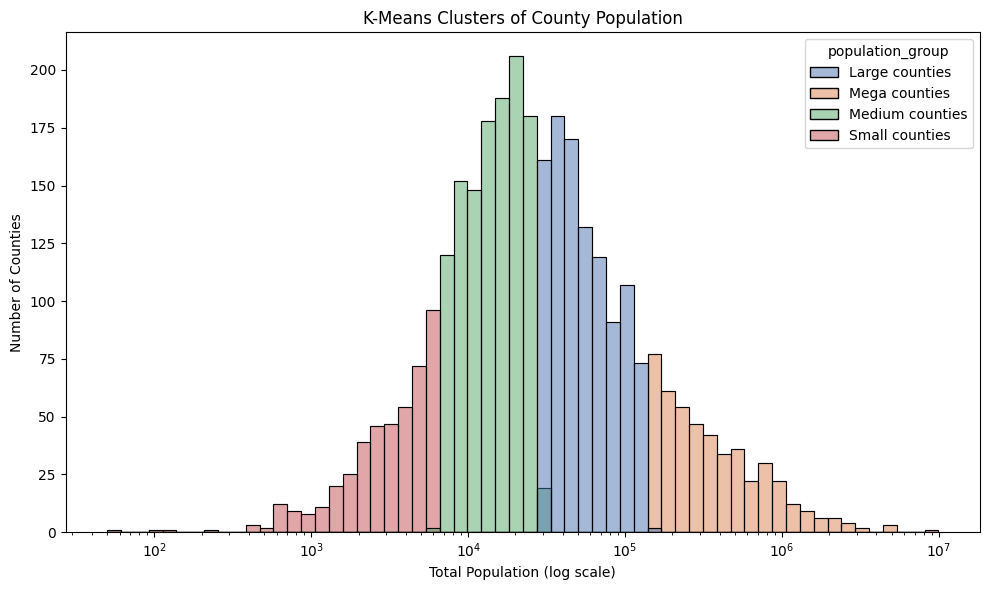

In [ ]:
#log transform
df["log_population"] = np.log1p(df["Total population"])


X = df[["log_population"]]
kmeans = KMeans(n_clusters=4, random_state=42)
df["pop_cluster"] = kmeans.fit_predict(X)

# Get cluster centers
centroids = kmeans.cluster_centers_.flatten()

# Order them small → large
ordered_clusters = np.argsort(centroids)

# Make label mapping
cluster_labels = {
    ordered_clusters[0]: "Small counties",
    ordered_clusters[1]: "Medium counties",
    ordered_clusters[2]: "Large counties",
    ordered_clusters[3]: "Mega counties"
}

# readable labels
df["population_group"] = df["pop_cluster"].map(cluster_labels)


plt.figure(figsize=(10,6))
sns.histplot(data=df, x="Total population", hue="population_group",
             log_scale=True, bins=60, palette="deep")
plt.title("K-Means Clusters of County Population")
plt.xlabel("Total Population (log scale)")
plt.ylabel("Number of Counties")
plt.tight_layout()
plt.show()


In [ ]:
income_by_pop_group = (
    df.groupby("population_group")["Median household income"]
      .median()
      .sort_index()
)

income_by_pop_group

,Median household income
population_group,
Large counties,62014.0
Medium counties,56338.0
Mega counties,76521.5
Small counties,58980.0


Counties seem to be sorted by size, with mega counties having the highest median household income, followed by large counties, then medium counties, and finally small counties. This made us wonder about the different types of jobs available in these differently sized counties. It also made us wonder about the strength of the correlation between county size and median household income. Since we are curious about the monotonic relationship rather than linear one, we chose the spearman correlation.

In [ ]:
corr_spearman = df["log_population"].corr(df["Median household income"], method="spearman")
corr_spearman

np.float64(0.3721042377681185)

The weakness of this correlation implies that there is a lot of variation between county wealth. Even though larger counties tend to have higher average median household incomes collectively, this relationship is not as strong when comparing all of the counties individually.

# Type of degree
Next we graphed the distributions of degree types together, in order to give more context.

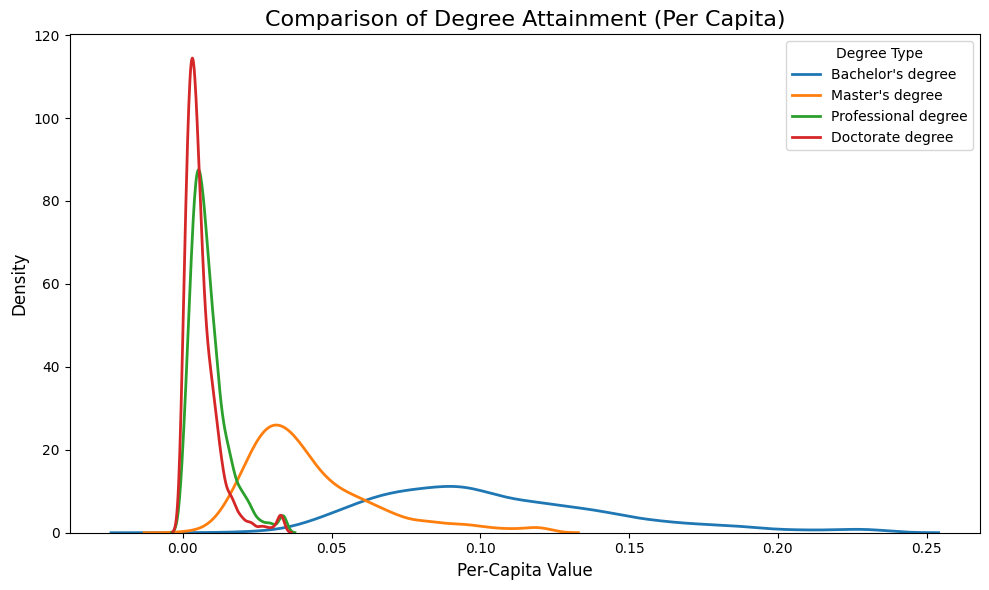

In [ ]:
degree_cols = [
    "Bachelor's degree_per_capita",
    "Master's degree_per_capita",
    "Professional degree_per_capita",
    "Doctorate degree_per_capita"
]

colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]

plt.figure(figsize=(10,6))

for col, color in zip(degree_cols, colors):
    data = df[col].dropna()

    # Cap extreme outliers for clean scaling
    cap = np.percentile(data, 99)
    data = np.clip(data, 0, cap)

    sns.kdeplot(data, color=color, linewidth=2, label=col.replace("_per_capita",""))

plt.title("Comparison of Degree Attainment (Per Capita)", fontsize=16)
plt.xlabel("Per-Capita Value", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.legend(title="Degree Type")
plt.tight_layout()
plt.show()


In [ ]:
#checkpoint
df.columns

Index(['County Name', 'Median household income', 'Total population',
       'Bachelor's degree', 'Master's degree', 'Professional degree',
       'Doctorate degree', 'state', 'county', 'White alone',
       'Black or African American alone',
       'American Indian and Alaska Native alone', 'Asian alone',
       'Native Hawaiian and Pacific Islander alone', 'Two or more races',
       'Hispanic or Latino', 'Same house 1 year ago', 'Moved within county',
       'Moved from different state', 'age_index',
       'Total population_per_capita', 'Bachelor's degree_per_capita',
       'Master's degree_per_capita', 'Professional degree_per_capita',
       'Doctorate degree_per_capita', 'White alone_per_capita',
       'Black or African American alone_per_capita',
       'American Indian and Alaska Native alone_per_capita',
       'Asian alone_per_capita',
       'Native Hawaiian and Pacific Islander alone_per_capita',
       'Two or more races_per_capita', 'Hispanic or Latino_per_capita',
    

# Race
In order to understand the distribution of racial groups, we will graph them individually and collectively.

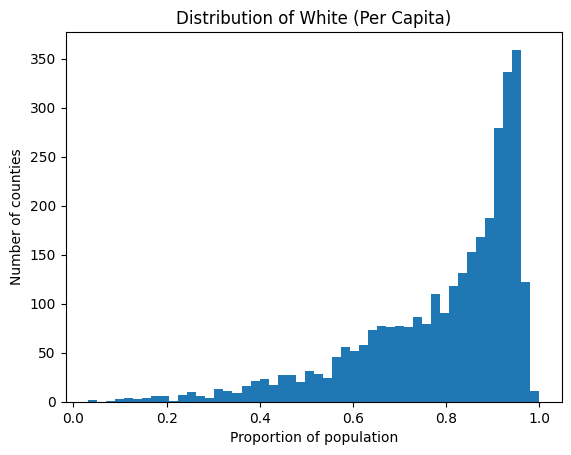

In [ ]:
plt.hist(df["White alone_per_capita"], bins=50)
plt.xlabel("Proportion of population")
plt.ylabel("Number of counties")
plt.title("Distribution of White (Per Capita)")
plt.show()

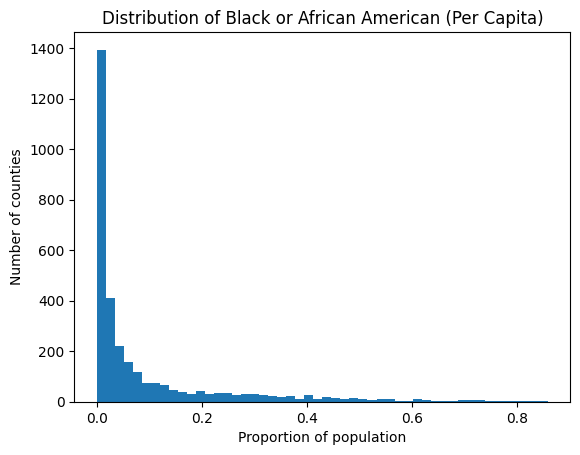

In [ ]:
plt.hist(df["Black or African American alone_per_capita"], bins=50)
plt.xlabel("Proportion of population")
plt.ylabel("Number of counties")
plt.title("Distribution of Black or African American (Per Capita)")
plt.show()

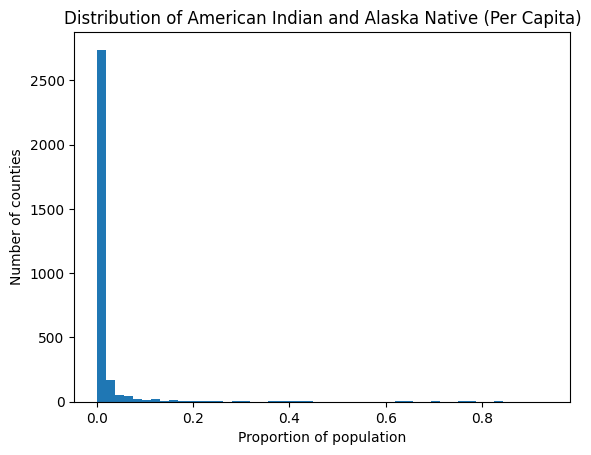

In [ ]:
plt.hist(df["American Indian and Alaska Native alone_per_capita"], bins=50)
plt.xlabel("Proportion of population")
plt.ylabel("Number of counties")
plt.title("Distribution of American Indian and Alaska Native (Per Capita)")
plt.show()

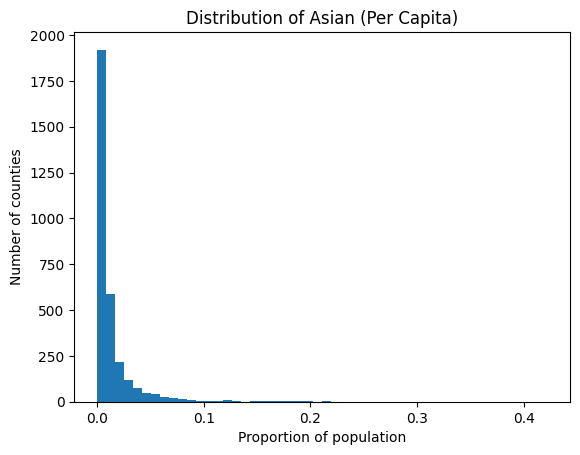

In [ ]:
plt.hist(df["Asian alone_per_capita"], bins=50)
plt.xlabel("Proportion of population")
plt.ylabel("Number of counties")
plt.title("Distribution of Asian (Per Capita)")
plt.show()

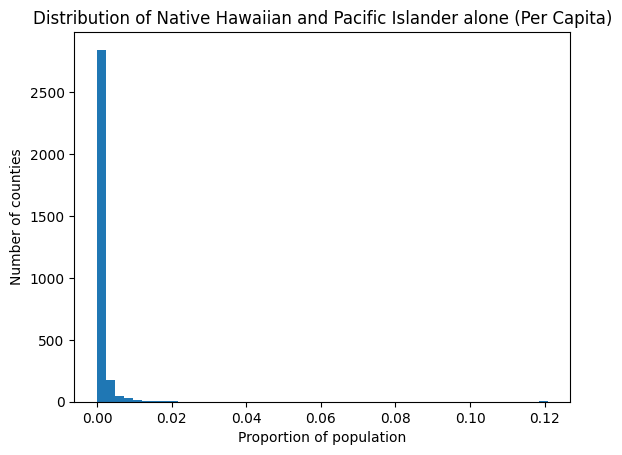

In [ ]:
plt.hist(df["Native Hawaiian and Pacific Islander alone_per_capita"], bins=50)
plt.xlabel("Proportion of population")
plt.ylabel("Number of counties")
plt.title("Distribution of Native Hawaiian and Pacific Islander alone (Per Capita)")
plt.show()

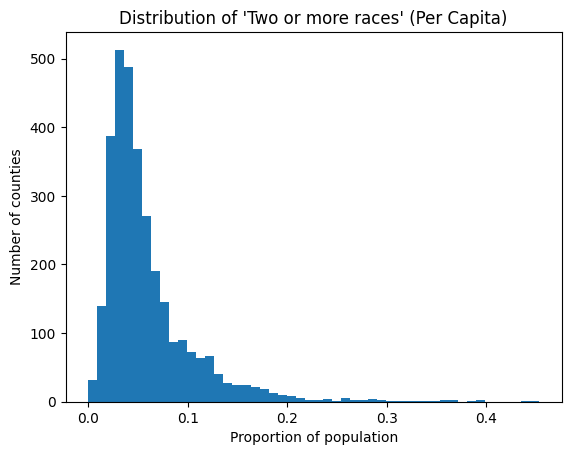

In [ ]:
plt.hist(df["Two or more races_per_capita"], bins=50)
plt.xlabel("Proportion of population")
plt.ylabel("Number of counties")
plt.title("Distribution of 'Two or more races' (Per Capita)")
plt.show()

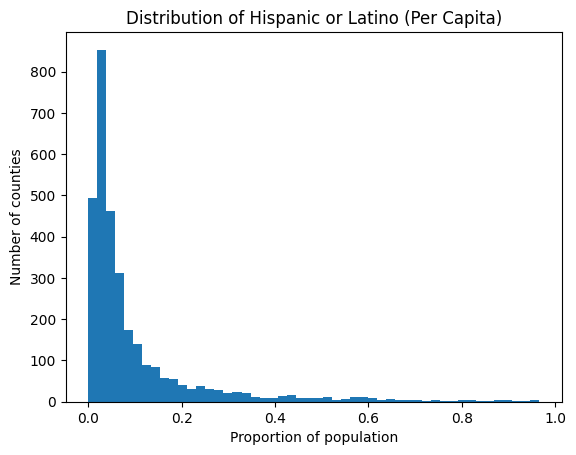

In [ ]:
plt.hist(df["Hispanic or Latino_per_capita"], bins=50)
plt.xlabel("Proportion of population")
plt.ylabel("Number of counties")
plt.title("Distribution of Hispanic or Latino (Per Capita)")
plt.show()

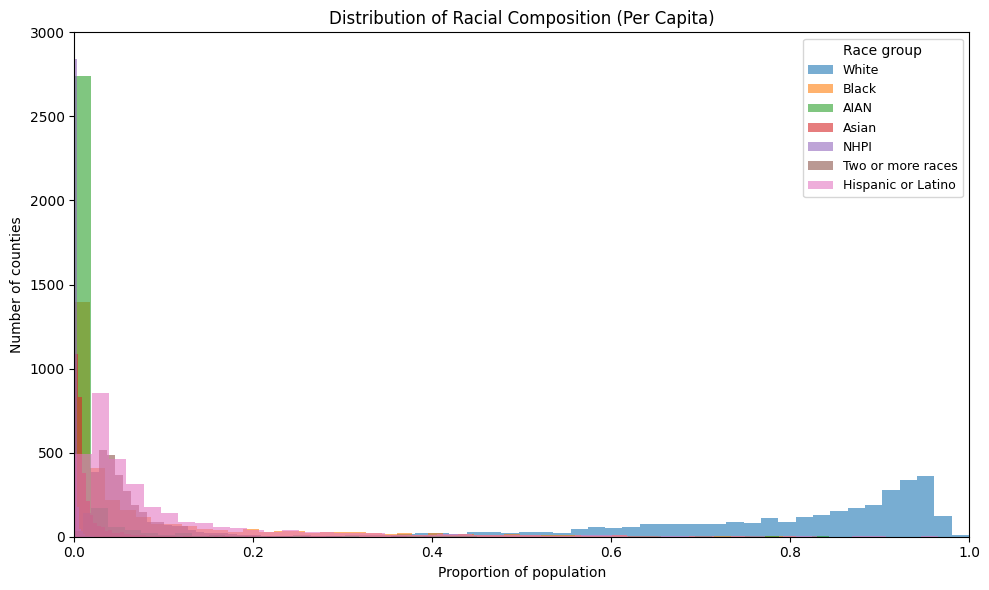

In [ ]:
plt.figure(figsize=(10,6))

plt.hist(df["White alone_per_capita"], bins=50, alpha=0.6, label="White")
plt.hist(df["Black or African American alone_per_capita"], bins=50, alpha=0.6, label="Black")
plt.hist(df["American Indian and Alaska Native alone_per_capita"], bins=50, alpha=0.6, label="AIAN")
plt.hist(df["Asian alone_per_capita"], bins=100, alpha=0.6, label="Asian")
plt.hist(df["Native Hawaiian and Pacific Islander alone_per_capita"], bins=50, alpha=0.6, label="NHPI")
plt.hist(df["Two or more races_per_capita"], bins=50, alpha=0.6, label="Two or more races")
plt.hist(df["Hispanic or Latino_per_capita"], bins=50, alpha=0.6, label="Hispanic or Latino")

plt.xlabel("Proportion of population")
plt.ylabel("Number of counties")
plt.title("Distribution of Racial Composition (Per Capita)")

plt.xlim(0, 1)
plt.ylim(0, 3000)

plt.legend(title="Race group", fontsize=9)
plt.tight_layout()
plt.show()


We know that graph is difficult to read! We chose to include it in order to demonstrate the differences in distributions. The smaller histograms have automatically adjusted scales, which give a better understanding of the distribution of each group. However, this larger histogram shows the distributions collectively, on a graph with the same x and y axis scale. For some groups (ex: American Indian and Alaska Native) there are many counties with an extremely low proportion of people living there. For other groups (ex: White) most counties have a high proportion of people living there. Note that this does not show the distribution of race by population, but rather by county. Each county gets the same weight, regardless of population size. This probably explains why there are a noticeable number of counties with a proportion of White people close to one: it likely represents the many small, rural counties with little racial diversity.

# State
Next, we added another column that labeled each county by state, in order to make visualizations about states more clear. We chose to include the data from both US states and territories, which is why there are more than 50 labels for 'state_name'.

In [ ]:
# State labels
state_fips_to_name = {
    "01": "Alabama",
    "02": "Alaska",
    "04": "Arizona",
    "05": "Arkansas",
    "06": "California",
    "08": "Colorado",
    "09": "Connecticut",
    "10": "Delaware",
    "11": "District of Columbia",
    "12": "Florida",
    "13": "Georgia",
    "15": "Hawaii",
    "16": "Idaho",
    "17": "Illinois",
    "18": "Indiana",
    "19": "Iowa",
    "20": "Kansas",
    "21": "Kentucky",
    "22": "Louisiana",
    "23": "Maine",
    "24": "Maryland",
    "25": "Massachusetts",
    "26": "Michigan",
    "27": "Minnesota",
    "28": "Mississippi",
    "29": "Missouri",
    "30": "Montana",
    "31": "Nebraska",
    "32": "Nevada",
    "33": "New Hampshire",
    "34": "New Jersey",
    "35": "New Mexico",
    "36": "New York",
    "37": "North Carolina",
    "38": "North Dakota",
    "39": "Ohio",
    "40": "Oklahoma",
    "41": "Oregon",
    "42": "Pennsylvania",
    "44": "Rhode Island",
    "45": "South Carolina",
    "46": "South Dakota",
    "47": "Tennessee",
    "48": "Texas",
    "49": "Utah",
    "50": "Vermont",
    "51": "Virginia",
    "53": "Washington",
    "54": "West Virginia",
    "55": "Wisconsin",
    "56": "Wyoming",

    # Territory labels
    "60": "American Samoa",
    "66": "Guam",
    "69": "Northern Mariana Islands",
    "72": "Puerto Rico",
    "78": "U.S. Virgin Islands"
}
df["state_name"] = df["state"].map(state_fips_to_name)
df.head()

,County Name,Median household income,Total population,Bachelor's degree,Master's degree,Professional degree,Doctorate degree,state,county,White alone,...,Native Hawaiian and Pacific Islander alone_per_capita,Two or more races_per_capita,Hispanic or Latino_per_capita,Same house 1 year ago_per_capita,Moved within county_per_capita,Moved from different state_per_capita,log_population,pop_cluster,population_group,state_name
0,"Autauga County, Alabama",68315,58761,6726,4014,702,437,01,001,43747,...,0.000000,0.042205,0.031722,0.020728,0.062780,0.069264,10.981251,3,Large counties,Alabama
1,"Baldwin County, Alabama",71039,233420,33474,15077,3483,2351,01,003,195998,...,0.000133,0.045575,0.048025,0.022834,0.056769,0.062861,12.360599,1,Mega counties,Alabama
2,"Barbour County, Alabama",39712,24877,1167,640,188,105,01,005,11309,...,0.000121,0.024480,0.048318,0.022390,0.067452,0.059372,10.121739,0,Medium counties,Alabama
3,"Bibb County, Alabama",50669,22251,1047,507,109,76,01,007,16872,...,0.000000,0.025976,0.029212,0.022021,0.072266,0.073165,10.010187,0,Medium counties,Alabama
4,"Blount County, Alabama",57440,59077,3840,1751,270,156,01,009,53941,...,0.001980,0.035615,0.096840,0.020499,0.056435,0.065051,10.986614,3,Large counties,Alabama


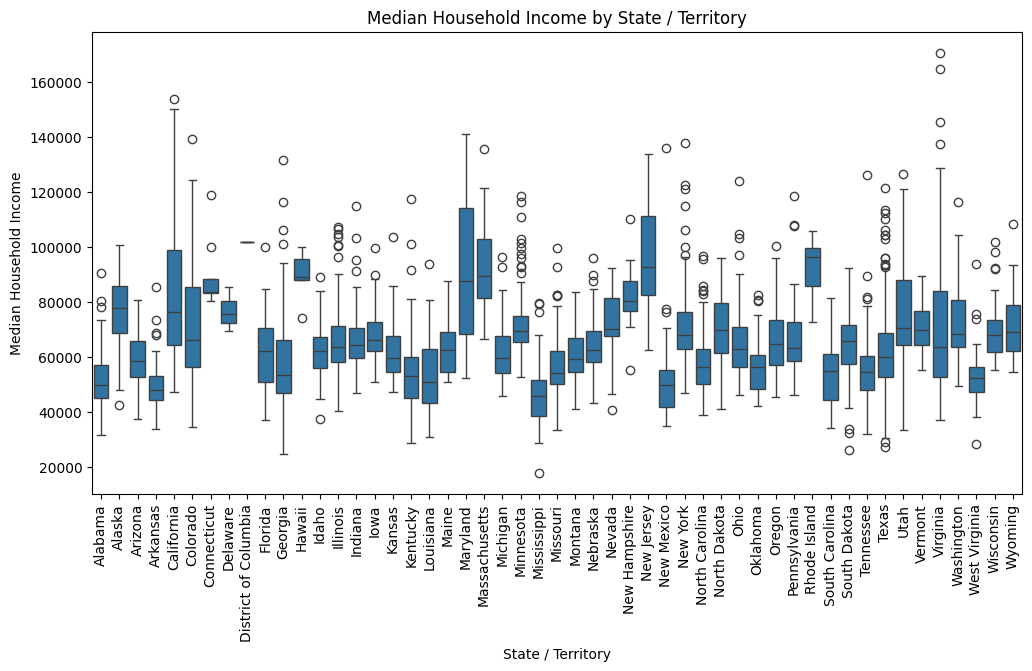

In [ ]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df, x="state_name", y="Median household income")
plt.xticks(rotation=90)
plt.title("Median Household Income by State / Territory")
plt.xlabel("State / Territory")
plt.ylabel("Median Household Income")
plt.show()


This plot shows the distribution of median household income by state or territory. We noticed some states have a particularly large spread, while others are very compact. One important limitation of this chart is the use of quartiles instead of variance. Each box represents the 25th-75th quartile, or a 'typical county' within the state. However, this does not illustrate states with many rural counties and several big cities very well because each county is weighted equally, so large urban counties do not dominate the distribution.

# Correlation matrix between many variables
For the correlation matrix, we will include several extra variables from the dataset not specifically explored above.

In [ ]:
#check point
df.columns

Index(['County Name', 'Median household income', 'Total population',
       'Bachelor's degree', 'Master's degree', 'Professional degree',
       'Doctorate degree', 'state', 'county', 'White alone',
       'Black or African American alone',
       'American Indian and Alaska Native alone', 'Asian alone',
       'Native Hawaiian and Pacific Islander alone', 'Two or more races',
       'Hispanic or Latino', 'Same house 1 year ago', 'Moved within county',
       'Moved from different state', 'age_index',
       'Total population_per_capita', 'Bachelor's degree_per_capita',
       'Master's degree_per_capita', 'Professional degree_per_capita',
       'Doctorate degree_per_capita', 'White alone_per_capita',
       'Black or African American alone_per_capita',
       'American Indian and Alaska Native alone_per_capita',
       'Asian alone_per_capita',
       'Native Hawaiian and Pacific Islander alone_per_capita',
       'Two or more races_per_capita', 'Hispanic or Latino_per_capita',
    

Correlation of features with Median Household Income:
Median household income                                  1.000000
Bachelor's degree_per_capita                             0.708967
Master's degree_per_capita                               0.626326
Professional degree_per_capita                           0.517472
Asian alone_per_capita                                   0.490245
Doctorate degree_per_capita                              0.416015
Moved from different state_per_capita                    0.193519
Moved within county_per_capita                           0.187413
Two or more races_per_capita                             0.112637
Native Hawaiian and Pacific Islander alone_per_capita    0.095058
White alone_per_capita                                   0.093081
Hispanic or Latino_per_capita                            0.058459
Same house 1 year ago_per_capita                        -0.036577
American Indian and Alaska Native alone_per_capita      -0.078008
age_index             

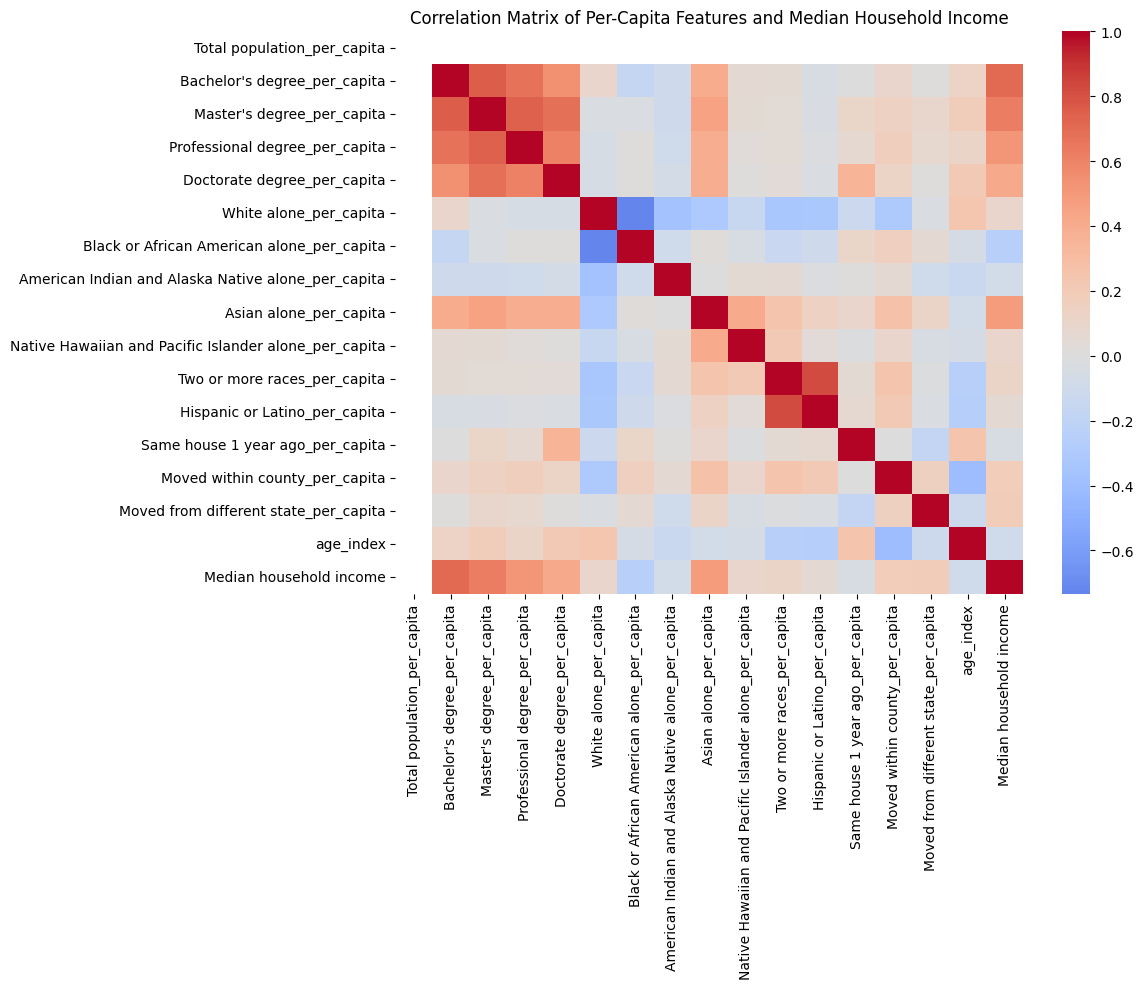

In [ ]:
# Set feature columns
feature_cols = [
    "Total population",
    "Bachelor's degree_per_capita",
    "Master's degree_per_capita",
    "Professional degree_per_capita",
    "Doctorate degree_per_capita",
    "White alone_per_capita",
    "Black or African American alone_per_capita",
    "American Indian and Alaska Native alone_per_capita",
    "Asian alone_per_capita",
    "Native Hawaiian and Pacific Islander alone_per_capita",
    "Two or more races_per_capita",
    "Hispanic or Latino_per_capita",
    "Same house 1 year ago_per_capita",
    "Moved within county_per_capita",
    "Moved from different state_per_capita",
    "age_index"
]

# Extract features and target
X = df[feature_cols]
y = df["Median household income"]

# Drop rows with any missing values (important for consistent correlations)
mask = X.notna().all(axis=1) & y.notna()
corr_df = df.loc[mask, feature_cols + ["Median household income"]]

# Compute correlation matrix
corr_matrix = corr_df.corr()

# Extract correlations with target variable
target_corr = corr_matrix["Median household income"].sort_values(ascending=False)

print("Correlation of features with Median Household Income:")
print(target_corr)

# Plot correlation heatmap
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, cmap="coolwarm", center=0)
plt.title("Correlation Matrix of Per-Capita Features and Median Household Income")
plt.tight_layout()
plt.show()

# Data Analysis
We will perform and compare OLS, Ridge, and Lasso regression.

# OLS Regression

In [ ]:
X = df[feature_cols].copy()
y = df["Median household income"].copy()

#drop any rows with NaN in features or target
mask = X.notna().all(axis=1) & y.notna()
X = X[mask]
y = y[mask]

#standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# test train split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [ ]:
# OLS Regression
y_train = y_train.astype(float)
X_train_ols = sm.add_constant(X_train)
ols_model = sm.OLS(y_train, X_train_ols).fit()

y_test = y_test.astype(float)
X_test_ols = sm.add_constant(X_test)
y_pred_ols = ols_model.predict(X_test_ols)

# regression equation
coef_names = ["Intercept"] + feature_cols
equation = " + ".join(f"{coef:.4f}*{name}" for coef, name in zip(ols_model.params, coef_names))
print("\nOLS Regression Equation:")
print(f"Median household income = {equation}")

# evaluation metrics
print(f"OLS RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_ols)):.2f}")
print(f"OLS R2: {r2_score(y_test, y_pred_ols):.3f}")


OLS Regression Equation:
Median household income = 63351.1450*Intercept + 0.0000*Total population_per_capita + 8156.9448*Bachelor's degree_per_capita + 3690.7974*Master's degree_per_capita + -837.9752*Professional degree_per_capita + -382.1450*Doctorate degree_per_capita + -7012.7422*White alone_per_capita + -9255.7339*Black or African American alone_per_capita + -4063.1308*American Indian and Alaska Native alone_per_capita + 2232.3165*Asian alone_per_capita + -833.2067*Native Hawaiian and Pacific Islander alone_per_capita + -2531.8197*Two or more races_per_capita + -868.1723*Hispanic or Latino_per_capita + 565.4766*Same house 1 year ago_per_capita + -35.2967*Moved within county_per_capita + 2263.0817*Moved from different state_per_capita + -3584.1493*age_index
OLS RMSE: 9796.60
OLS R2: 0.608


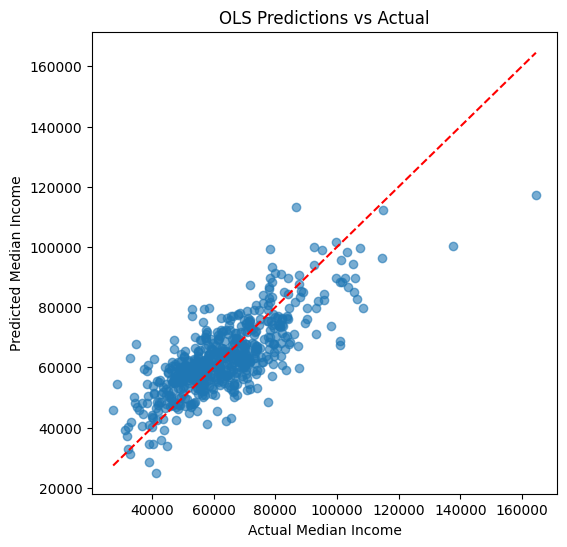

In [ ]:
# plot predictions
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_ols, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Median Income")
plt.ylabel("Predicted Median Income")
plt.title("OLS Predictions vs Actual")
plt.show()

# Ridge Regression

In [ ]:
# ridge regression
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)
y_pred_ridge = ridge_model.predict(X_test)

print(f"Ridge RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_ridge)):.2f}")
print(f"Ridge R2: {r2_score(y_test, y_pred_ridge):.3f}")

# print regression equation
equation_ridge = " + ".join(f"{coef:.4f}*{name}" for coef, name in zip(ridge_model.coef_, feature_cols))
print("\nRidge Regression Equation:")
print(f"Median household income = {ridge_model.intercept_:.4f} + {equation_ridge}")

Ridge RMSE: 9789.01
Ridge R2: 0.608

Ridge Regression Equation:
Median household income = 63350.1293 + 0.0000*Total population_per_capita + 8152.1683*Bachelor's degree_per_capita + 3689.4315*Master's degree_per_capita + -831.6195*Professional degree_per_capita + -381.8790*Doctorate degree_per_capita + -6695.2907*White alone_per_capita + -8989.4559*Black or African American alone_per_capita + -3919.1694*American Indian and Alaska Native alone_per_capita + 2296.1876*Asian alone_per_capita + -821.7071*Native Hawaiian and Pacific Islander alone_per_capita + -2473.3370*Two or more races_per_capita + -795.0074*Hispanic or Latino_per_capita + 563.1025*Same house 1 year ago_per_capita + -35.9260*Moved within county_per_capita + 2265.2531*Moved from different state_per_capita + -3580.6555*age_index


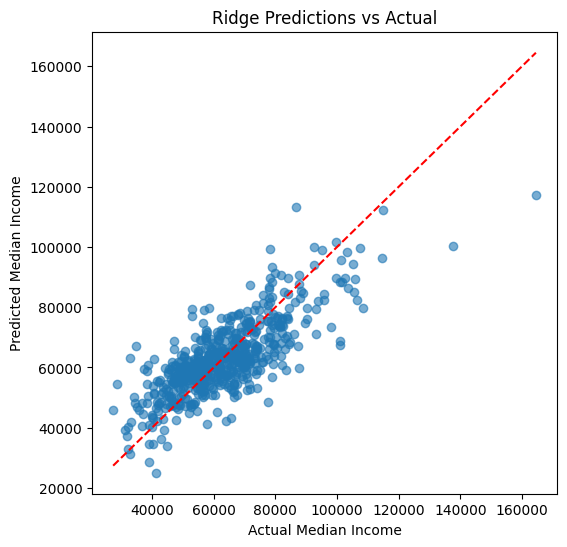

In [ ]:
# plot predictions
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_ridge, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Median Income")
plt.ylabel("Predicted Median Income")
plt.title("Ridge Predictions vs Actual")
plt.show()

Alpha Values Tried and Corresponding RMSEs:
alpha=0.0010    RMSE=9796.5896
alpha=0.0027    RMSE=9796.5760
alpha=0.0072    RMSE=9796.5396
alpha=0.0193    RMSE=9796.4421
alpha=0.0518    RMSE=9796.1813
alpha=0.1389    RMSE=9795.4867
alpha=0.3728    RMSE=9793.6598
alpha=1.0000    RMSE=9789.0077
alpha=2.6827    RMSE=9778.0975
alpha=7.1969    RMSE=9756.9852
alpha=19.3070   RMSE=9728.8226
alpha=51.7947   RMSE=9705.5925
alpha=138.9495   RMSE=9693.6880
alpha=372.7594   RMSE=9729.8536
alpha=1000.0000   RMSE=9946.6800

Best alpha: 138.9495494373136
Lowest RMSE: 9693.6880


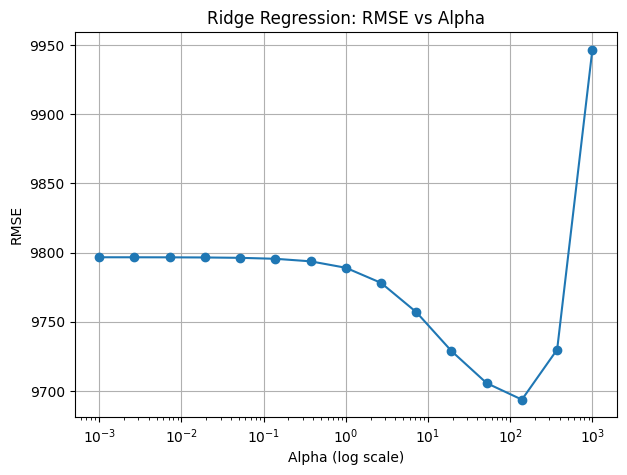


Optimal Ridge Alpha: 138.9495494373136


In [ ]:
def choose_ridge_alpha(X_train, y_train, X_test, y_test, alphas=None):

    if alphas is None:
        alphas = np.logspace(-3, 3, 15)

    rmses = []

    print("Alpha Values Tried and Corresponding RMSEs:")

    for alpha in alphas:
        model = Ridge(alpha=alpha)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        rmses.append(rmse)

        print(f"alpha={alpha:<7.4f}   RMSE={rmse:.4f}")

    # find best alpha
    best_idx = np.argmin(rmses)
    best_alpha = alphas[best_idx]
    best_rmse = rmses[best_idx]

    print("\nBest alpha:", best_alpha)
    print(f"Lowest RMSE: {best_rmse:.4f}")

    # plot RMSE vs alpha
    plt.figure(figsize=(7,5))
    plt.plot(alphas, rmses, marker='o')
    plt.xscale("log")
    plt.xlabel("Alpha (log scale)")
    plt.ylabel("RMSE")
    plt.title("Ridge Regression: RMSE vs Alpha")
    plt.grid(True)
    plt.show()

    # refit best model
    best_model = Ridge(alpha=best_alpha).fit(X_train, y_train)

    return best_model, best_alpha, rmses

best_ridge_model, best_alpha, rmses = choose_ridge_alpha(
    X_train, y_train, X_test, y_test
)
print("\nOptimal Ridge Alpha:", best_alpha)

In [ ]:
# ridge regression (repeated with best alpha)
ridge_model = Ridge(alpha=best_alpha)
ridge_model.fit(X_train, y_train)
y_pred_ridge = ridge_model.predict(X_test)

print(f"Ridge RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_ridge)):.2f}")
print(f"Ridge R2: {r2_score(y_test, y_pred_ridge):.3f}")

# print regression equation
equation_ridge = " + ".join(f"{coef:.4f}*{name}" for coef, name in zip(ridge_model.coef_, feature_cols))
print("\nRidge Regression Equation:")
print(f"Median household income = {ridge_model.intercept_:.4f} + {equation_ridge}")

Ridge RMSE: 9693.69
Ridge R2: 0.616

Ridge Regression Equation:
Median household income = 63338.8347 + 0.0000*Total population_per_capita + 7400.5507*Bachelor's degree_per_capita + 3563.3746*Master's degree_per_capita + -264.0907*Professional degree_per_capita + -166.0703*Doctorate degree_per_capita + -28.1455*White alone_per_capita + -3365.1871*Black or African American alone_per_capita + -908.5333*American Indian and Alaska Native alone_per_capita + 3490.9608*Asian alone_per_capita + -530.7938*Native Hawaiian and Pacific Islander alone_per_capita + -938.2608*Two or more races_per_capita + 508.0268*Hispanic or Latino_per_capita + 334.7079*Same house 1 year ago_per_capita + 56.1268*Moved within county_per_capita + 2185.7990*Moved from different state_per_capita + -3265.6052*age_index


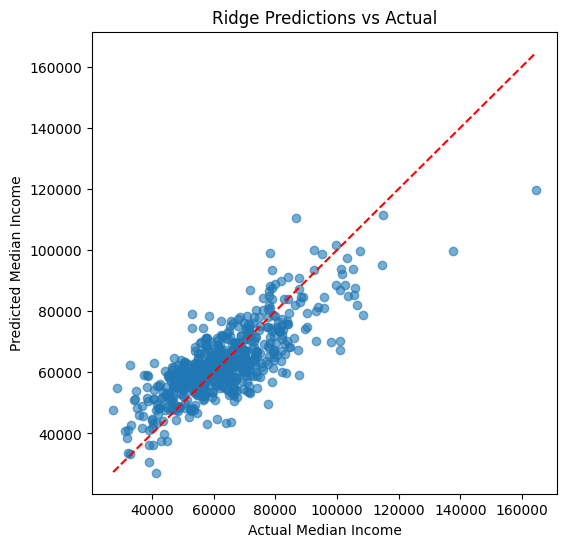

In [ ]:
# plot predictions (repeated with best alpha)
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_ridge, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Median Income")
plt.ylabel("Predicted Median Income")
plt.title("Ridge Predictions vs Actual")
plt.show()

# Lasso Regression

In [ ]:
# lasso regression
lasso_model = Lasso(alpha=0.01, max_iter=10000)
lasso_model.fit(X_train, y_train)
y_pred_lasso = lasso_model.predict(X_test)

print(f"Lasso RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_lasso)):.2f}")
print(f"Lasso R2: {r2_score(y_test, y_pred_lasso):.3f}")

# Print regression equation
equation_lasso = " + ".join(f"{coef:.4f}*{name}" for coef, name in zip(lasso_model.coef_, feature_cols))
print("\nLasso Regression Equation:")
print(f"Median household income = {lasso_model.intercept_:.4f} + {equation_lasso}")

Lasso RMSE: 9796.56
Lasso R2: 0.608

Lasso Regression Equation:
Median household income = 63351.1413 + 0.0000*Total population_per_capita + 8156.9322*Bachelor's degree_per_capita + 3690.7551*Master's degree_per_capita + -837.9303*Professional degree_per_capita + -382.1153*Doctorate degree_per_capita + -7011.4841*White alone_per_capita + -9254.6803*Black or African American alone_per_capita + -4062.5544*American Indian and Alaska Native alone_per_capita + 2232.5518*Asian alone_per_capita + -833.1460*Native Hawaiian and Pacific Islander alone_per_capita + -2531.5989*Two or more races_per_capita + -867.8612*Hispanic or Latino_per_capita + 565.4460*Same house 1 year ago_per_capita + -35.2815*Moved within county_per_capita + 2263.0842*Moved from different state_per_capita + -3584.1187*age_index


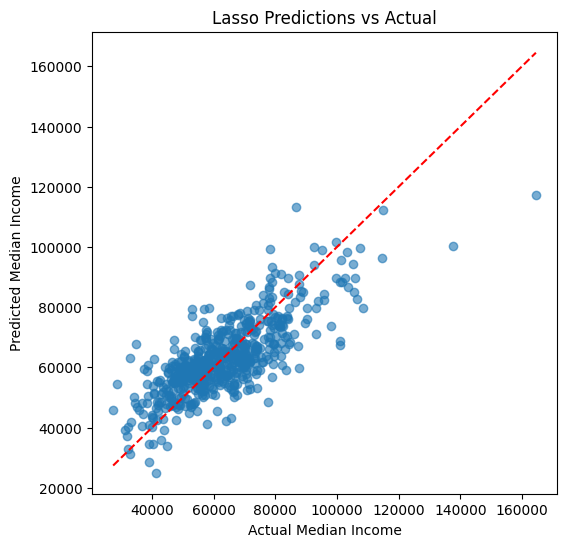

In [ ]:
# plot predictions
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_lasso, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Median Income")
plt.ylabel("Predicted Median Income")
plt.title("Lasso Predictions vs Actual")
plt.show()

Alpha Values Tried and Corresponding RMSEs:
alpha=0.0010    RMSE=9796.5942
alpha=0.0027    RMSE=9796.5883
alpha=0.0072    RMSE=9796.5727
alpha=0.0193    RMSE=9796.5309
alpha=0.0518    RMSE=9796.4186
alpha=0.1389    RMSE=9796.1175
alpha=0.3728    RMSE=9795.3123
alpha=1.0000    RMSE=9793.1680
alpha=2.6827    RMSE=9787.5280
alpha=7.1969    RMSE=9773.2083
alpha=19.3070   RMSE=9740.6421
alpha=51.7947   RMSE=9691.5559
alpha=138.9495   RMSE=9653.6905
alpha=372.7594   RMSE=9621.4795
alpha=1000.0000   RMSE=9687.3468

Best alpha: 372.7593720314938
Lowest RMSE: 9621.4795


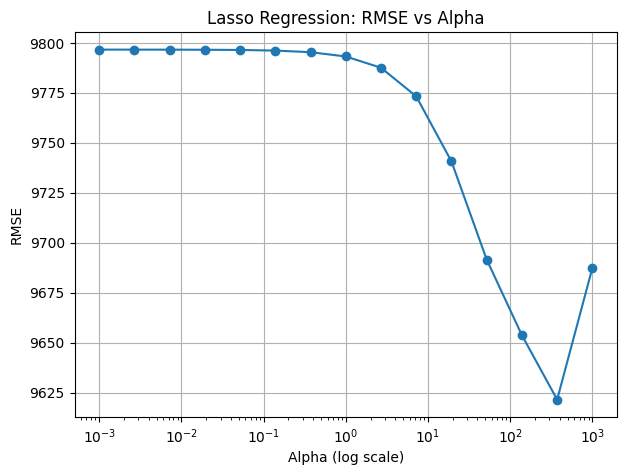

In [ ]:
#finding the best alpha
def choose_lasso_alpha(X_train, y_train, X_test, y_test, alphas=None):
    if alphas is None:
        alphas = np.logspace(-3, 3, 15)

    rmses = []

    print("Alpha Values Tried and Corresponding RMSEs:")

    for alpha in alphas:
        model = Lasso(alpha=alpha, max_iter=10000)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        rmses.append(rmse)

        print(f"alpha={alpha:<7.4f}   RMSE={rmse:.4f}")

    #find best alpha
    best_idx = np.argmin(rmses)
    best_alpha = alphas[best_idx]
    best_rmse = rmses[best_idx]

    print("\nBest alpha:", best_alpha)
    print(f"Lowest RMSE: {best_rmse:.4f}")

    #plot RMSE vs alpha
    plt.figure(figsize=(7,5))
    plt.plot(alphas, rmses, marker='o')
    plt.xscale("log")
    plt.xlabel("Alpha (log scale)")
    plt.ylabel("RMSE")
    plt.title("Lasso Regression: RMSE vs Alpha")
    plt.grid(True)
    plt.show()

    #train best model
    best_model = Lasso(alpha=best_alpha, max_iter=10000).fit(X_train, y_train)

    return best_model, best_alpha, rmses

best_lasso_model, best_lasso_alpha, lasso_rmses = choose_lasso_alpha(
    X_train, y_train, X_test, y_test
)

In [ ]:
#lasso regression
lasso_model = Lasso(alpha=best_lasso_alpha, max_iter=10000)
lasso_model.fit(X_train, y_train)
y_pred_lasso = lasso_model.predict(X_test)

print(f"Lasso RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_lasso)):.2f}")
print(f"Lasso R2: {r2_score(y_test, y_pred_lasso):.3f}")

# print regression equation
equation_lasso = " + ".join(f"{coef:.4f}*{name}" for coef, name in zip(lasso_model.coef_, feature_cols))
print("\nLasso Regression Equation:")
print(f"Median household income = {lasso_model.intercept_:.4f} + {equation_lasso}")

Lasso RMSE: 9621.48
Lasso R2: 0.622

Lasso Regression Equation:
Median household income = 63337.8126 + 0.0000*Total population_per_capita + 7812.5896*Bachelor's degree_per_capita + 2913.5227*Master's degree_per_capita + -0.0000*Professional degree_per_capita + 0.0000*Doctorate degree_per_capita + 0.0000*White alone_per_capita + -2902.2974*Black or African American alone_per_capita + -562.8189*American Indian and Alaska Native alone_per_capita + 3110.1404*Asian alone_per_capita + -246.4651*Native Hawaiian and Pacific Islander alone_per_capita + -3.9181*Two or more races_per_capita + 0.0000*Hispanic or Latino_per_capita + 0.0000*Same house 1 year ago_per_capita + 0.0000*Moved within county_per_capita + 2022.1356*Moved from different state_per_capita + -2862.3732*age_index


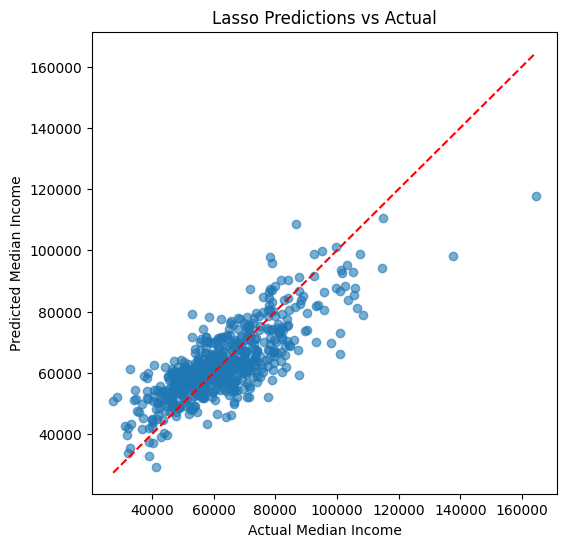

In [ ]:
#plot predictions
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_lasso, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Median Income")
plt.ylabel("Predicted Median Income")
plt.title("Lasso Predictions vs Actual")
plt.show()

# Model Evaluation

In [ ]:
#fit OLS Regression
X_train_ols = sm.add_constant(X_train)
ols_model = sm.OLS(y_train, X_train_ols).fit()

# Extract coefficients + p-values
p_values = ols_model.pvalues
coefs = ols_model.params

results_table = pd.DataFrame({
    "Coefficient": coefs,
    "p_value": p_values
})

print("\n=== OLS Coefficients and P-Values ===")
print(results_table)

# identify statistically significant predictors
significant_predictors = results_table[results_table["p_value"] < 0.05]
print("\n=== Statistically Significant Predictors (p < 0.05) ===")
print(significant_predictors)

# identify non-significant predictors
nonsignificant_predictors = results_table[results_table["p_value"] >= 0.05]
print("\n=== Non-Significant Predictors (p >= 0.05) ===")
print(nonsignificant_predictors)


=== OLS Coefficients and P-Values ===
        Coefficient        p_value
const  6.335115e+04   0.000000e+00
x1     9.987581e-12   6.951920e-14
x2     8.156945e+03  1.275354e-117
x3     3.690797e+03   6.043762e-21
x4    -8.379752e+02   1.042603e-02
x5    -3.821450e+02   2.028617e-01
x6    -7.012742e+03   6.810078e-07
x7    -9.255734e+03   8.478407e-15
x8    -4.063131e+03   1.050491e-09
x9     2.232317e+03   5.225096e-09
x10   -8.332067e+02   1.931390e-04
x11   -2.531820e+03   2.586740e-08
x12   -8.681723e+02   8.375290e-02
x13    5.654766e+02   1.388946e-02
x14   -3.529667e+01   8.843434e-01
x15    2.263082e+03   1.244253e-25
x16   -3.584149e+03   3.461580e-45

=== Statistically Significant Predictors (p < 0.05) ===
        Coefficient        p_value
const  6.335115e+04   0.000000e+00
x1     9.987581e-12   6.951920e-14
x2     8.156945e+03  1.275354e-117
x3     3.690797e+03   6.043762e-21
x4    -8.379752e+02   1.042603e-02
x6    -7.012742e+03   6.810078e-07
x7    -9.255734e+03   8.47840

In [ ]:
# fit OLS Regression
X_train_ols = sm.add_constant(X_train)   # add intercept
ols_model = sm.OLS(y_train, X_train_ols).fit()

# build variable name list
variable_names = ["const"] + feature_cols

# build labeled table
results_table = pd.DataFrame({
    "Variable": variable_names,
    "Coefficient": ols_model.params,
    "p_value": ols_model.pvalues
})

print("OLS COEFFICIENTS & P-VALUES")
print(results_table.to_string(index=False))

# statistically significant predictors
significant = results_table[results_table["p_value"] < 0.05]

print("SIGNIFICANT PREDICTORS (p < 0.05)")
print("These variables are statistically meaningful.")
print(significant.to_string(index=False))

# Non-significant predictors
nonsignificant = results_table[results_table["p_value"] >= 0.05]

print("NON-SIGNIFICANT PREDICTORS (p >= 0.05)")
print("These variables do NOT significantly predict income.")
print(nonsignificant.to_string(index=False))

OLS COEFFICIENTS & P-VALUES
                                             Variable   Coefficient       p_value
                                                const  6.335115e+04  0.000000e+00
                          Total population_per_capita  9.987581e-12  6.951920e-14
                         Bachelor's degree_per_capita  8.156945e+03 1.275354e-117
                           Master's degree_per_capita  3.690797e+03  6.043762e-21
                       Professional degree_per_capita -8.379752e+02  1.042603e-02
                          Doctorate degree_per_capita -3.821450e+02  2.028617e-01
                               White alone_per_capita -7.012742e+03  6.810078e-07
           Black or African American alone_per_capita -9.255734e+03  8.478407e-15
   American Indian and Alaska Native alone_per_capita -4.063131e+03  1.050491e-09
                               Asian alone_per_capita  2.232317e+03  5.225096e-09
Native Hawaiian and Pacific Islander alone_per_capita -8.332067e+02  1

In [ ]:
# fit Lasso Regression
lasso_model = Lasso(alpha=best_lasso_alpha, max_iter=10000)
lasso_model.fit(X_train, y_train)

# build variable name list
variable_names = feature_cols

# build labeled table
results_table_lasso = pd.DataFrame({
    "Variable": variable_names,
    "Coefficient": lasso_model.coef_
})

print("LASSO COEFFICIENTS")
print(results_table_lasso.to_string(index=False))

# identify variables Lasso keep
lasso_kept = results_table_lasso[results_table_lasso["Coefficient"] != 0]

print("LASSO: VARIABLES SELECTED (Coefficient ≠ 0)")
print("These predictors contribute to the model.")
print(lasso_kept.to_string(index=False))

# identify variables Lasso dropped
lasso_dropped = results_table_lasso[results_table_lasso["Coefficient"] == 0]

print("LASSO: VARIABLES REMOVED (Coefficient = 0)")
print("These predictors are shrunk fully to zero.")
print(lasso_dropped.to_string(index=False))

LASSO COEFFICIENTS
                                             Variable  Coefficient
                          Total population_per_capita     0.000000
                         Bachelor's degree_per_capita  7812.589585
                           Master's degree_per_capita  2913.522679
                       Professional degree_per_capita    -0.000000
                          Doctorate degree_per_capita     0.000000
                               White alone_per_capita     0.000000
           Black or African American alone_per_capita -2902.297440
   American Indian and Alaska Native alone_per_capita  -562.818863
                               Asian alone_per_capita  3110.140378
Native Hawaiian and Pacific Islander alone_per_capita  -246.465102
                         Two or more races_per_capita    -3.918140
                        Hispanic or Latino_per_capita     0.000000
                     Same house 1 year ago_per_capita     0.000000
                       Moved within county_

Since Bachelor's degree per capita was identified as the most important predictor of county income, we will revisit some metrics with respect to bachelor's degree per capital.  

In [ ]:
df.iloc[0,:]

,0
County Name,"Autauga County, Alabama"
Median household income,68315
Total population,58761
Bachelor's degree,6726
Master's degree,4014
Professional degree,702
Doctorate degree,437
state,01
county,001
White alone,43747


In [ ]:
# Prepare variables
X = df["Bachelor's degree_per_capita"]
y = df["Median household income"]

y = pd.to_numeric(y, errors="coerce").dropna()

X = X[y.index]
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
print(model.summary())


                               OLS Regression Results                              
Dep. Variable:     Median household income   R-squared:                       0.503
Model:                                 OLS   Adj. R-squared:                  0.502
Method:                      Least Squares   F-statistic:                     3174.
Date:                     Fri, 12 Dec 2025   Prob (F-statistic):               0.00
Time:                             18:39:01   Log-Likelihood:                -33944.
No. Observations:                     3143   AIC:                         6.789e+04
Df Residuals:                         3141   BIC:                         6.790e+04
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------

This makes sense, since the original OLS produced a correlation coefficient of 0.7089, which is the square root of this R-squared (0.503).

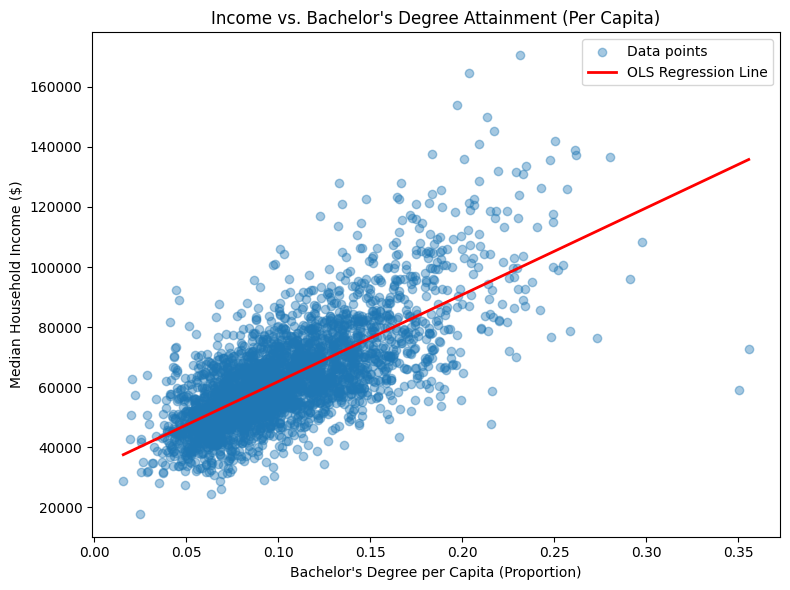

In [ ]:
# Extract columns
x = df["Bachelor's degree_per_capita"]
y = df["Median household income"]

# Convert to numeric and drop any rows that fail conversion
x = pd.to_numeric(x, errors="coerce")
y = pd.to_numeric(y, errors="coerce")

# Drop rows where either is NaN
valid = x.notna() & y.notna()
x = x[valid]
y = y[valid]

# Fit OLS model
X_sm = sm.add_constant(x)
model = sm.OLS(y, X_sm).fit()

# Prepare prediction line
x_sorted = np.sort(x)
X_pred = sm.add_constant(x_sorted)
y_pred = model.predict(X_pred)

# Plot
plt.figure(figsize=(8,6))
plt.scatter(x, y, alpha=0.4, label="Data points")
plt.plot(x_sorted, y_pred, color="red", linewidth=2, label="OLS Regression Line")

plt.title("Income vs. Bachelor's Degree Attainment (Per Capita)")
plt.xlabel("Bachelor's Degree per Capita (Proportion)")
plt.ylabel("Median Household Income ($)")
plt.legend()
plt.tight_layout()
plt.show()


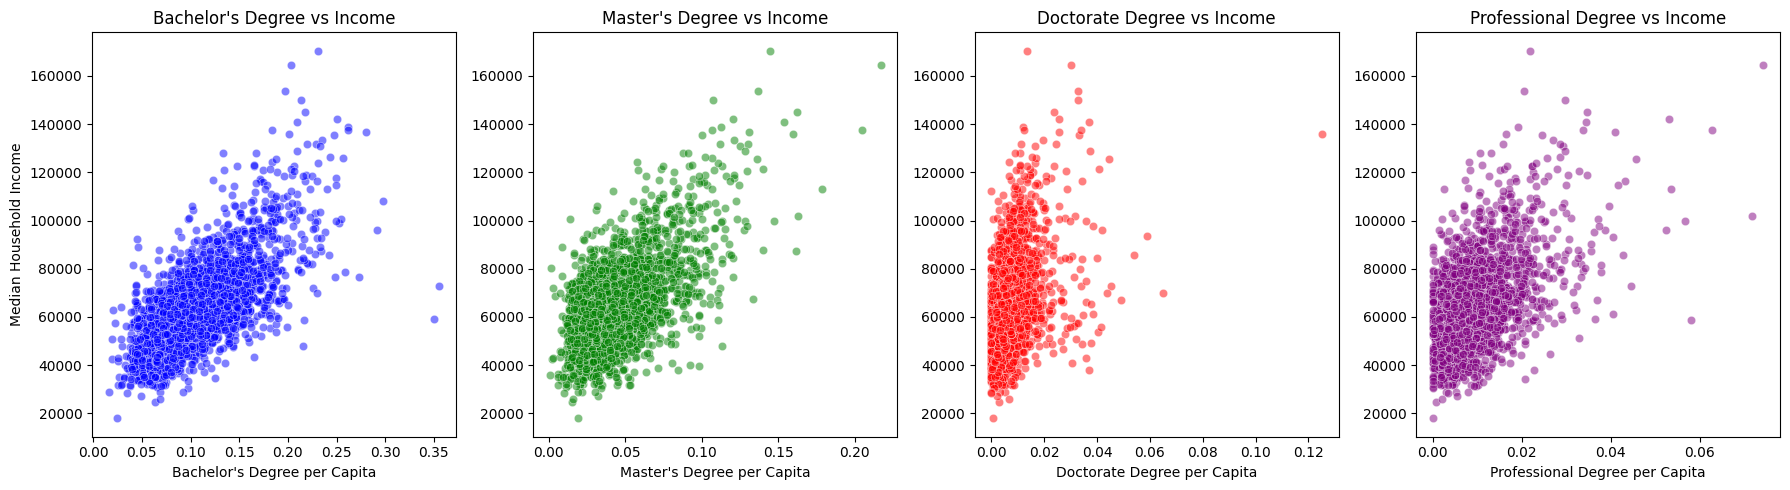

In [ ]:
# Extract variables and convert to numeric
bachelor = pd.to_numeric(df["Bachelor's degree_per_capita"], errors="coerce")
master = pd.to_numeric(df["Master's degree_per_capita"], errors="coerce")
doctorate = pd.to_numeric(df["Doctorate degree_per_capita"], errors="coerce")
professional = pd.to_numeric(df["Professional degree_per_capita"], errors="coerce")
income = pd.to_numeric(df["Median household income"], errors="coerce")

# Drop rows with NaN in any column
valid = bachelor.notna() & master.notna() & doctorate.notna() & professional.notna() & income.notna()
bachelor = bachelor[valid]
master = master[valid]
doctorate = doctorate[valid]
professional = professional[valid]
income = income[valid]

plt.figure(figsize=(18,5))

# Bachelor's vs Income
plt.subplot(1, 4, 1)
sns.scatterplot(x=bachelor, y=income, color="blue", alpha=0.5)
plt.title("Bachelor's Degree vs Income")
plt.xlabel("Bachelor's Degree per Capita")
plt.ylabel("Median Household Income")

# Master's vs Income
plt.subplot(1, 4, 2)
sns.scatterplot(x=master, y=income, color="green", alpha=0.5)
plt.title("Master's Degree vs Income")
plt.xlabel("Master's Degree per Capita")
plt.ylabel("")

# Doctorate vs Income
plt.subplot(1, 4, 3)
sns.scatterplot(x=doctorate, y=income, color="red", alpha=0.5)
plt.title("Doctorate Degree vs Income")
plt.xlabel("Doctorate Degree per Capita")
plt.ylabel("")

# Professional vs Income
plt.subplot(1, 4, 4)
sns.scatterplot(x=professional, y=income, color="purple", alpha=0.5)
plt.title("Professional Degree vs Income")
plt.xlabel("Professional Degree per Capita")
plt.ylabel("")

plt.tight_layout()
plt.show()


These scatterplots show the distribution of median household income by degree type.

# Report
Objective:

  This project set out to use ACS 5-year data obtained through the U.S. Census API to attain valuable insights that point to predictors of financial trends accross different counties/census tracts.

Process:

  To obtain this data, we obtained a Census API key, then made 4 queries to obtain the following categories of data; income and education variables, demographic data, age data and mobility indicators. We then renamed these variables in separate dataframes so they could be more interpretable before concatinating the 4 data frames using pd.merge(how='inner') on the 'County Name'. After pulling age brackets directly from the ACS data, we realized that having one variable for each ~5 year age bracket was not productive for analysis. As such, we constructed an ordinal variable that was a weighted average of the presence of each of the age brackets from the original dataset ([5-9] maps to 0, [10-14] maps to 1 and so on). This way, we could have a continuous variable that took into account the age index of each observation.

  After assembling the dataframe, we moved to visuallizing the distributions of each of the variables. Aside from the ID variables (like 'County Name' and 'State') and median income, since it is not a count, we used the same style of chart with automatic scaling to examine the frequency of appearances with different raw amounts variables like doctorate degrees, african americans, etc. The age index that we constructed functioned in the same way (displayed the frequency with which each value of the age index appeared).

  After visuallizing these distributions, we divided each of these count variables (except age index) by the total population for each observation so that each of the counts could avoid collinearity with total population. We then added these per capita features to the dataframe so that they could be used for later analysis. Since using division in this way could lead to values from [-inf,inf], we replaced these values with NaN values, then dropped these rows from the dataset.

  After creating these per capita features, we used them, along with age index in a correlation matrix to observe the initial relationships between variables. Before creating the correlation matrix, we standardized each of the predictors, not because it would affect the pearson correlation coefficients, but because they needed to be standardized for our later use of regularized regression. The relationships we were most keen to observe were the pearson correlation coefficients between each of the predictors and median household income (our outcome variable of choice).

  After we made the correlation matrix, we split the data into train and test sets, with test size .2. We then used OLS from scikitlearn to fit an OLS model, then we printed its equation as well as its R^2 (percent of variation explained) and RMSE (standard deviation of residuals) as evaluators, and plotted its predictions vs the actual data with a 45 degree line as a reference.

  After the OLS model, used Ridge and Lasso from scikitlearn with arbitrary alpha values to have as baselines. We printed these regression equations as well as R^2 and RMSE as evaluators. Then, we used helper functions to iterate over a space of alpha values (with a range such that on a graph of alpha values vs. RMSE, the absolute minima would be clear) for each both the Ridge and Lasso regressions to find the optimal alpha value by seeing which alpha had the lowest RMSE.

  After finding these optimal alphas, we made final optimal models, printed their equations, RMSEs and R^2's. We also plotted the predictions of these final, optimal models.

  The reason we sought to use regularized regression here was because of the correlation matrix. The matrix showed high positive correlation between certain features, and we worried about this being grounds for collinearity, contaminating results. As such, we used regularized regression to reduce the size of the coefficients in hopes that eliminating this potential threat would improve model performance.

  As a final quality check, we ran a stat test on the statistical significance of the OLS coefficients, as well as a check on which coefficients the Lasso model reduced to 0 because of collinearity.

  Results:

  Count Distributions:
  All of the count distributions were unimodal with a strong right skew with a couple of notable top end outliers. The 2 exceptions were median household income and age index. These variables were much closer to being normally distributed, both being unimodal, and much more symmetrical.

  Correlation Matrix:

  The 5 variables with the strongest correlations with the target were:
  
  Bachelor's degree_per_capita                                       0.708967
  
  Master's degree_per_capita                                         0.626326
  
  Professional degree_per_capita                                     0.517472
  
  Asian alone_per_capita                                             0.490245
  
  Doctorate degree_per_capita                                        0.416015
  
  Because the data was scaled before making this matrix, these 5 are likely also the strongest predictors of median household income in a tract.

  It is worth noting that all of the degree variables, which measured whether or not a person had each degree were collinear. This makes sense logically, as it is presumed that a Bachelor's degree is required for any kind of graduate degree, meaning they are not independent of one another. The rest of the pearson correlation coefficents are listed by the matrix visuallization.

  OLS Regression:

  The regression equation was as follows with RMSE and R^2 at the bottom:

  Median household income = 63351.1450*Intercept + 0.0000*Total population_per_capita + 8156.9448*Bachelor's degree_per_capita + 3690.7974*Master's degree_per_capita + -837.9752*Professional degree_per_capita + -382.1450*Doctorate degree_per_capita + -7012.7422*White alone_per_capita + -9255.7339*Black or African American alone_per_capita + -4063.1308*American Indian and Alaska Native alone_per_capita + 2232.3165*Asian alone_per_capita + -833.2067*Native Hawaiian and Pacific Islander alone_per_capita + -2531.8197*Two or more races_per_capita + -868.1723*Hispanic or Latino_per_capita + 565.4766*Same house 1 year ago_per_capita + -35.2967*Moved within county_per_capita + 2263.0817*Moved from different state_per_capita + -3584.1493*age_index

  OLS RMSE: 9796.60

  OLS R2: 0.608

  This means that this model explains .608 percent of the variance in median income with a residual standard deviation of $9796.60.

  All of the top 5 predictors from the correlation matrix reached statistical significance at the a=.05 level except for per capita doctorate degrees, which had a p value of 0.202862.

  The 5 coefficients with the largest magnitudes (per capita) were Bachelor's degree, Master's degree, african american alone (per capita amount of black monoracial people), white alone (same as the african american alone, but for white) and two or more races. The black and white alone coefficients were stronly negative. This indicates that tracts with the highest median incomes were likely more educated and more ethnically diverse. Asian alone had the 6th highest coefficient in positive ~ $2232. This was the only monoracial group whose increased presence actually predicted an increase in median income.

  *Note: We will only be discussing the coefficients of the optimal ridge and lasso models in our analysis, but we will discuss why those alpha values were optimal.

  Ridge:

  The optimal alpha value was 138.9495494373136 with a regression equation and evaluators that follow:

  Ridge RMSE: 9693.69

  Ridge R2: 0.616

  Ridge Regression Equation:

  Median household income = 63338.8347 + 0.0000*Total population_per_capita + 7400.5507*Bachelor's degree_per_capita + 3563.3746*Master's degree_per_capita + -264.0907*Professional degree_per_capita + -166.0703*Doctorate degree_per_capita + -28.1455*White alone_per_capita + -3365.1871*Black or African American alone_per_capita + -908.5333*American Indian and Alaska Native alone_per_capita + 3490.9608*Asian alone_per_capita + -530.7938*Native Hawaiian and Pacific Islander alone_per_capita + -938.2608*Two or more races_per_capita + 508.0268*Hispanic or Latino_per_capita + 334.7079*Same house 1 year ago_per_capita + 56.1268*Moved within county_per_capita + 2185.7990*Moved from different state_per_capita + -3265.6052*age_index

  This alpha value, which is somewhat large was likely optimal because of the collinear nature of the degree per capita features, and potentially demographic collinearity which may arise from certain demographics migrating in tandem, thus excluding others from being in the same tract.

  The 5 predictors with the highest magnitude coefficients were (per capita) Bachelor's degree, Master's degree, black alone, asian alone and age index. Compared to OLS, the magnitude of the Master's degree coefficient halved. In addition, variables like 2 or more races and white alone disappeared from the top 5. Asian alone's positive covariation also became greater. This results indicate that penalizing potentially collinear predictors revealed that education and asians per capita were still the most potent predictors. Blacks per capita stayed as a potent negative predictor, and was joined this time by age index. Age index's index makes sense considering that older people are much more likely to be retired, meaning that the income they incur is reduced. Black people per capita makes sense as a negative predictor given that this demographic is also positively associated with many poverty measures. The Asian coefficent represents the opposite phenomenon. It is also important to note that the moved from a different state variable remained a potent positive predictor in this regression, being the 6th largest coefficient in this regression. This could be explained by the notion that only the people with the financial means are able to move across state lines.

  Lasso:

  The optimal lasso value was 372.7593720314938 with an RMSE, R^2 and regression equation that follows:

  Lasso RMSE: 9621.48
  
  Lasso R2: 0.622

  Lasso Regression Equation:

  Median household income = 63337.8126 + 0.0000*Total population_per_capita + 7812.5896*Bachelor's degree_per_capita + 2913.5227*Master's degree_per_capita + -0.0000*Professional degree_per_capita + 0.0000*Doctorate degree_per_capita + 0.0000*White alone_per_capita + -2902.2974*Black or African American alone_per_capita + -562.8189*American Indian and Alaska Native alone_per_capita + 3110.1404*Asian alone_per_capita + -246.4651*Native Hawaiian and Pacific Islander alone_per_capita + -3.9181*Two or more races_per_capita + 0.0000*Hispanic or Latino_per_capita + 0.0000*Same house 1 year ago_per_capita + 0.0000*Moved within county_per_capita + 2022.1356*Moved from different state_per_capita + -2862.3732*age_index

  This similarly large alpha value also makes sense given the same concerns of collinearity that were present in the previous 2 regressions. Since Lasso has the capacity to reduce collinear predictors' coefficients to 0, we also tracked which coefficents were non-zero and which weren't. The lists are as follows:

  ==========================================
LASSO: VARIABLES SELECTED (Coefficient ≠ 0)
These predictors contribute to the model.
==========================================
                                            
                                            Variable  Coefficient
                         Bachelor's degree_per_capita  7812.589585
                           Master's degree_per_capita  2913.522679
           Black or African American alone_per_capita -2902.297440
    American Indian and Alaska Native alone_per_capita  -562.818863
                               Asian alone_per_capita  3110.140378
    Native Hawaiian and Pacific Islander alone_per_capita  -246.465102
                         Two or more races_per_capita    -3.918140
                Moved from different state_per_capita  2022.135638
                                            age_index -2862.373240

====================================================
LASSO: VARIABLES REMOVED (Coefficient = 0)
These predictors are shrunk fully to zero.
====================================================
                        
                        Variable  Coefficient
     Total population_per_capita          0.0
    Professional degree_per_capita         -0.0
    Doctorate degree_per_capita          0.0
          White alone_per_capita          0.0
    Hispanic or Latino_per_capita          0.0
    Same house 1 year ago_per_capita          0.0
    Moved within county_per_capita          0.0

The top 5 predictors in coefficient magnitude in this regression remain the same as in the ridge regression. This time however, the magnitude of asian alone surpassed that of a masters degree. This change is likely due to the fact that bachelor's and master's degress are not independent, and a stronger penalty for collinearity lowered the master's coefficient, otherwise, this model indicates the same things as the ridge model. It is also important to note that professional degree, doctorate degree, white alone, hispanic/latino alone, same house 1 year ago and moved county were all eliminated from this equation. This makes sense since the first 2 are both additional education variables, the demographic ones are likley indicative of zero-sum demographic co-migration, and the last 2 are collinear with moved from different state. The takeaways from this model are largely the same as those from the ridge model.



Model Comparison:

The optimal lasso model outperformed all of the other models indicating that collinearity between features was a valid concern. As this model had the lowest RMSE and the highest R^2, we should interpret its coefficients with the greatest level of certainty.

*It is important to note that there may have been non-linear trends relating other variables to median income that could not be captured do to linear regression's focus on linear patterns.

Actionable Insights:

The insight with the highest potential actionability is the strength of the coefficients relating to bachelor's and master's degrees. These being strong predictors of income may point policymakers to move toward policies that make achieving these degrees easier, increasing average income, and taxable revenue.

What is also important is the coefficients of the black alone and asian alone variables. Black alone being such a strong negative indicator may prompt policy makers to examine other economic/well being indicators that also have strong negative covariation with this variable in order to isolate causal sources of this disparity. This same thought process can be applied to the asian alone variable, looking at other economic/well being indcators that have strong postitive covariations with the asian alone variable. It is crucial to recognize that our analysis is NOT causal, and as a result, it is not appropriate to conclude that there are characteristics innate to black and asian people in the United States that make them more/less predisposed to succeeeding economically.

The age index and moved state variables are much less interesting in terms of being actionable. The strength of their coefficients both indicate specific stories that cannot really be affected by policy. Age being a negative indicator of income just suggests that older people (more likley to be retired) make less money, which is obvious. The moved state variable being a positive indicator of income likely signifies selection bias, in that only people with the financial means to move states actually do. This means that this process is likely costly, which is a rather ambiguous notion in the context of policy.